# Disability Progression in Multiple Sclerosis from EDSS Scores
This tutorial notebook demonstrates the usage of some key functions in this repository.

In [1]:
import numpy as np
import pandas as pd
import lifelines

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("whitegrid", {"grid_color": "gainsboro"})

from definitions import baselines, progression
from evaluation import cohort, survival

In [2]:
# This refreshes any modules upon change
%load_ext autoreload
%autoreload 2

In [3]:
# Black is a Python code formatter
# https://black.readthedocs.io/en/stable/
# NOTE: This is not required for the tutorial
# to work, just don't execute if you don't feel
# like installing Black.
%load_ext blackcellmagic

## Input data format
* Data have to be provided in tabular form, e.g. as .xlsx or .csv file. 
* For annotating the baseline score and the first progression event, the data must have at least:
    * One column for the EDSS score
    * One column for the timestamp
* To analyze time to progression on cohort level, each follow-up must also have its unique ID.

### Important
* The timestamp must be provided as integer or float, e.g. as the numbers of days or weeks after baseline.
* The data have to be ordered in time from first to last assessment.
* The timestamps must be unique, i.e. there mustn't be two assessments with the same timestamp.

### Single follow-up example

In [4]:
single_follow_up_df = pd.DataFrame(
    [
        {"days_after_baseline": 0, "edss_score": 5.0},
        {"days_after_baseline": 12, "edss_score": 4.5},
        {"days_after_baseline": 24, "edss_score": 4.5},
        {"days_after_baseline": 36, "edss_score": 5.0},
        {"days_after_baseline": 48, "edss_score": 4.5},
        {"days_after_baseline": 60, "edss_score": 4.0},
        {"days_after_baseline": 72, "edss_score": 3.5},
        {"days_after_baseline": 84, "edss_score": 5.5},
        {"days_after_baseline": 96, "edss_score": 5.5},
        {"days_after_baseline": 108, "edss_score": 4.5},
    ]
)

### Cohort-level
We provide a simple, synthetic example cohort in ``data/examples/sampled_follow_ups.xlsx``.

In [5]:
cohort_follow_ups = pd.read_excel("data/examples/sampled_follow_ups.xlsx")

In [6]:
cohort_follow_ups.head()

,follow_up_id,days_after_baseline,edss_score
0,0,0,3.0
1,0,287,3.0
2,0,462,3.0
3,0,553,3.0
4,0,727,3.0


## Annotating the baseline
The definitions for fixed baseline and roving reference are provided as module in ``definitions/baselines.py``.

The function ``baselines.annotate_baseline()`` takes as input one follow-up, i.e. it has to be applied to each follow-up
separately. Below is an example of how to apply it to a single follow-up, and an example of how to use this function on
cohort level by using a helper function provided in ``evaluation/cohort.py``.

### Single follow-up

In [7]:
single_follow_up_df_with_baseline = baselines.annotate_baseline(
    follow_up_dataframe=single_follow_up_df,
    baseline_type="roving",
    edss_score_column_name="edss_score",
    time_column_name="days_after_baseline",
    reference_score_column_name="reference_edss_score",
)

In [8]:
single_follow_up_df_with_baseline

,days_after_baseline,edss_score,reference_edss_score,reference_edss_score_days_after_baseline
0,0,5.0,NaN,NaN
1,12,4.5,5.0,0.0
2,24,4.5,4.5,12.0
3,36,5.0,4.5,12.0
4,48,4.5,4.5,12.0
5,60,4.0,4.5,12.0
6,72,3.5,4.0,60.0
7,84,5.5,3.5,72.0
8,96,5.5,3.5,72.0
9,108,4.5,3.5,72.0


### Cohort-level
To facilitate computations for cohort-level data, we provide some helper functions in ``evaluation/cohort.py``.

The function ``cohort.annotate_baseline_cohort_level()`` takes the same arguments as the single follow-up annotation function, and an additional argument for the name of the column where the follow-up ID is provided.

In [9]:
cohort_follow_ups_with_baseline = cohort.annotate_baseline_cohort_level(
    follow_up_dataframe=cohort_follow_ups,
    baseline_type="roving",
    id_column_name="follow_up_id",
    edss_score_column_name="edss_score",
    time_column_name="days_after_baseline",
    reference_score_column_name="reference_edss_score",
)

In [10]:
# Show the output for a follow_up
example_id = 0
cohort_follow_ups_with_baseline[cohort_follow_ups_with_baseline["follow_up_id"] == example_id]

,follow_up_id,days_after_baseline,edss_score,reference_edss_score,reference_edss_score_days_after_baseline
0,0,0,3.0,NaN,NaN
1,0,287,3.0,3.0,0.0
2,0,462,3.0,3.0,0.0
3,0,553,3.0,3.0,0.0
4,0,727,3.0,3.0,0.0
5,0,1091,4.0,3.0,0.0
6,0,1263,4.0,3.0,0.0
7,0,1417,2.5,3.0,0.0
8,0,1515,2.5,2.5,1417.0
9,0,1861,2.5,2.5,1417.0


## Annotate the first progression event
The definitions for *first progression event* are provided as module in ``definitions/progression.py``.

The function ``baselines.annotate_first_progression()`` takes as input one follow-up with annotated baseline,
i.e. it has to be applied to each follow-up separately. Below is an example of how to apply it to a single 
follow-up, and an example of how to use this function on cohort level by using a helper function provided in ``evaluation/cohort.py``.

### Single follow-up

In [11]:
single_follow_up_df_with_baseline_and_progression = (
    progression.annotate_first_progression(
        follow_up_dataframe=single_follow_up_df_with_baseline,
        edss_score_column_name="edss_score",
        time_column_name="days_after_baseline",
        opt_increase_threshold=5.5, # require + 1.0 up to and including this value, + 0.5 above
        opt_larger_minimal_increase_from_0=True, # require + 1.5 from reference EDSS 0
        opt_minimal_distance_time=0, # minimal distance to previous or reference
        opt_minimal_distance_type="reference",  # "reference" or "previous"
        opt_minimal_distance_backtrack_monotonic_decrease=True, # see documentation
        opt_require_confirmation=False, # require confirmation (True or False)
        opt_confirmation_time=-1,  # -1 for sustained over follow-up
        opt_confirmation_type="minimum",  # "minimum" or "monotonic"
        opt_confirmation_included_values="all",  # "last" or "all"
        reference_score_column_name="reference_edss_score",
        first_progression_flag_column_name="is_first_progression",
    )
)

In [12]:
single_follow_up_df_with_baseline_and_progression

,days_after_baseline,edss_score,reference_edss_score,reference_edss_score_days_after_baseline,is_first_progression
0,0,5.0,NaN,NaN,False
1,12,4.5,5.0,0.0,False
2,24,4.5,4.5,12.0,False
3,36,5.0,4.5,12.0,False
4,48,4.5,4.5,12.0,False
5,60,4.0,4.5,12.0,False
6,72,3.5,4.0,60.0,False
7,84,5.5,3.5,72.0,True
8,96,5.5,3.5,72.0,False
9,108,4.5,3.5,72.0,False


### Cohort-level
To facilitate computations for cohort-level data, we provide some helper functions in ``evaluation/cohort.py``.

The function ``cohort.annotate_progression_cohort_level()`` takes the same arguments as the single follow-up annotation function, and an additional argument for the name of the column where the follow-up ID is provided.

In [13]:
cohort_follow_ups_with_baseline_and_progression = (
    cohort.annotate_first_progression_cohort_level(
        follow_up_dataframe=cohort_follow_ups_with_baseline,
        id_column_name="follow_up_id",
        edss_score_column_name="edss_score",
        time_column_name="days_after_baseline",
        opt_increase_threshold=5.5,
        opt_larger_minimal_increase_from_0=True,
        opt_minimal_distance_time=0,
        opt_minimal_distance_type="reference",
        opt_minimal_distance_backtrack_monotonic_decrease=True,
        opt_require_confirmation=False,
        opt_confirmation_time=-1,
        opt_confirmation_type="minimum",
        opt_confirmation_included_values="all",
        reference_score_column_name="reference_edss_score",
        first_progression_flag_column_name="is_first_progression",
    )
)

In [14]:
# Show the output for a follow_up
example_id = 0
cohort_follow_ups_with_baseline_and_progression[cohort_follow_ups_with_baseline_and_progression["follow_up_id"] == example_id]

,follow_up_id,days_after_baseline,edss_score,reference_edss_score,reference_edss_score_days_after_baseline,is_first_progression
0,0,0,3.0,NaN,NaN,False
1,0,287,3.0,3.0,0.0,False
2,0,462,3.0,3.0,0.0,False
3,0,553,3.0,3.0,0.0,False
4,0,727,3.0,3.0,0.0,False
5,0,1091,4.0,3.0,0.0,True
6,0,1263,4.0,3.0,0.0,False
7,0,1417,2.5,3.0,0.0,False
8,0,1515,2.5,2.5,1417.0,False
9,0,1861,2.5,2.5,1417.0,False


## Get the time to first progression

### Single follow-up

In [15]:
single_follow_up_time_to_progression = survival.get_time_to_first_progression(
    follow_up_dataframe=single_follow_up_df_with_baseline_and_progression,
    edss_score_column_name="edss_score",
    time_column_name="days_after_baseline",
    reference_score_column_name="reference_edss_score",
    first_progression_flag_column_name="is_first_progression",
    additional_columns_to_drop=[],
    progression_event_found_column_name="progression",
    time_to_progression_column_name="time_to_first_progression",
    reference_for_progression_column_name="reference_for_progression",
    progression_score_column_name="progression_score",
    length_of_follow_up_column_name="length_of_follow_up",
)

In [16]:
single_follow_up_time_to_progression

,progression,time_to_first_progression,reference_for_progression,progression_score,length_of_follow_up
0,True,84,3.5,5.5,108


### Single follow-up with additional constant columns
Constant columns such as follow-up IDs are retained; if you have additional non-constant columns (e.g. if you write your own baseline/progression annotation and keep helper columns such as a flag for the baseline entry), you have to drop them explicitly.

In [17]:
# Create a little example...
single_follow_up_df_with_baseline_and_progression_with_additional_cols = (
    single_follow_up_df_with_baseline_and_progression.copy()
)
single_follow_up_df_with_baseline_and_progression_with_additional_cols["constant"] = 12
single_follow_up_df_with_baseline_and_progression_with_additional_cols[
    "non_constant"
] = single_follow_up_df_with_baseline_and_progression_with_additional_cols.index

In [18]:
single_follow_up_df_with_baseline_and_progression_with_additional_cols

,days_after_baseline,edss_score,reference_edss_score,reference_edss_score_days_after_baseline,is_first_progression,constant,non_constant
0,0,5.0,NaN,NaN,False,12,0
1,12,4.5,5.0,0.0,False,12,1
2,24,4.5,4.5,12.0,False,12,2
3,36,5.0,4.5,12.0,False,12,3
4,48,4.5,4.5,12.0,False,12,4
5,60,4.0,4.5,12.0,False,12,5
6,72,3.5,4.0,60.0,False,12,6
7,84,5.5,3.5,72.0,True,12,7
8,96,5.5,3.5,72.0,False,12,8
9,108,4.5,3.5,72.0,False,12,9


In [19]:
survival.get_time_to_first_progression(
    follow_up_dataframe=single_follow_up_df_with_baseline_and_progression_with_additional_cols,
    edss_score_column_name="edss_score",
    time_column_name="days_after_baseline",
    reference_score_column_name="reference_edss_score",
    first_progression_flag_column_name="is_first_progression",
    additional_columns_to_drop=["non_constant"],
    progression_event_found_column_name="progression",
    time_to_progression_column_name="time_to_first_progression",
    reference_for_progression_column_name="reference_for_progression",
    progression_score_column_name="progression_score",
    length_of_follow_up_column_name="length_of_follow_up",
)

,constant,progression,time_to_first_progression,reference_for_progression,progression_score,length_of_follow_up
0,12,True,84,3.5,5.5,108


### Cohort-level
To facilitate computations for cohort-level data, we provide some helper functions in ``evaluation/cohort.py``.

The function ``cohort.get_time_to_first_progression_cohort_level()`` takes the same arguments as the single follow-up annotation function, and an additional argument for the name of the column where the follow-up ID is provided.

In [20]:
cohort_follow_ups_time_to_progression = (
    cohort.get_time_to_first_progression_cohort_level(
        follow_up_dataframe=cohort_follow_ups_with_baseline_and_progression,
        id_column_name="follow_up_id",
        edss_score_column_name="edss_score",
        time_column_name="days_after_baseline",
        reference_score_column_name="reference_edss_score",
        first_progression_flag_column_name="is_first_progression",
        additional_columns_to_drop=[],
        progression_event_found_column_name="progression",
        time_to_progression_column_name="time_to_first_progression",
        reference_for_progression_column_name="reference_for_progression",
        progression_score_column_name="progression_score",
        length_of_follow_up_column_name="length_of_follow_up",
    )
)

In [21]:
cohort_follow_ups_time_to_progression

,follow_up_id,progression,time_to_first_progression,reference_for_progression,progression_score,length_of_follow_up
0,0,True,1091.0,3.0,4.0,2066
0,1,True,672.0,2.0,3.0,1771
0,2,True,196.0,1.5,2.5,1515
0,3,True,1147.0,3.5,4.5,1451
0,4,True,855.0,6.0,6.5,2018
...,...,...,...,...,...,...
0,195,True,875.0,4.0,5.5,1268
0,196,True,287.0,3.0,4.0,1481
0,197,True,302.0,2.0,4.5,1567
0,198,False,NaN,NaN,NaN,1397


## Survival analysis with lifelines
We use https://lifelines.readthedocs.io/en/latest/index.html for survival analysis.

### Get the right input data format
The ``fit()`` function for the lifelines ``KaplanMeierFitter`` requires at least a duration (to event or censoring) and a flag whether the event was observed.

#### Get *duration* and *observed* from ``get_time_to_first_progression()`` output

In [22]:
# Event was observed
survival.get_lifelines_input_data(
    first_progression_flag=True,
    time_to_first_progression=200,
    length_of_follow_up=300,
    global_censoring=None,
    duration_name="duration",
    observed_name="observed",
)

{'duration': 200, 'observed': True}

In [23]:
# Event was not observed
survival.get_lifelines_input_data(
    first_progression_flag=False,
    time_to_first_progression=np.NaN,
    length_of_follow_up=300,
    global_censoring=None,
    duration_name="duration",
    observed_name="observed",
)

{'duration': 300, 'observed': False}

#### Apply on cohort-level

In [24]:
cohort_follow_ups_time_to_progression_for_lifelines = (
    cohort.get_lifelines_input_data_cohort_level(
        times_to_first_progression_dataframe=cohort_follow_ups_time_to_progression,
        progression_event_found_column_name="progression",
        time_to_progression_column_name="time_to_first_progression",
        length_of_follow_up_column_name="length_of_follow_up",
        global_censoring=None,
        duration_name="duration",
        observed_name="observed",
    )
)

In [25]:
cohort_follow_ups_time_to_progression_for_lifelines

,follow_up_id,progression,time_to_first_progression,reference_for_progression,progression_score,length_of_follow_up,duration,observed
0,0,True,1091.0,3.0,4.0,2066,1091.0,True
0,1,True,672.0,2.0,3.0,1771,672.0,True
0,2,True,196.0,1.5,2.5,1515,196.0,True
0,3,True,1147.0,3.5,4.5,1451,1147.0,True
0,4,True,855.0,6.0,6.5,2018,855.0,True
...,...,...,...,...,...,...,...,...
0,195,True,875.0,4.0,5.5,1268,875.0,True
0,196,True,287.0,3.0,4.0,1481,287.0,True
0,197,True,302.0,2.0,4.5,1567,302.0,True
0,198,False,NaN,NaN,NaN,1397,1397.0,False


### Use Kaplan-Meier to get the median survival time and 95%CI, and the event rate

In [26]:
survival.get_median_survival_time_kaplan_meier(
    times_to_event_df=cohort_follow_ups_time_to_progression_for_lifelines,
    durations_column_name="duration",
    observed_column_name="observed",
)

,n_events,event_rate,median_time_to_first_progression,median_time_to_first_progression_lower_95CI,median_time_to_first_progression_upper_95CI
0,150,0.75,901.0,761.0,1053.0


### Plot a simple Kaplan-Meier graph

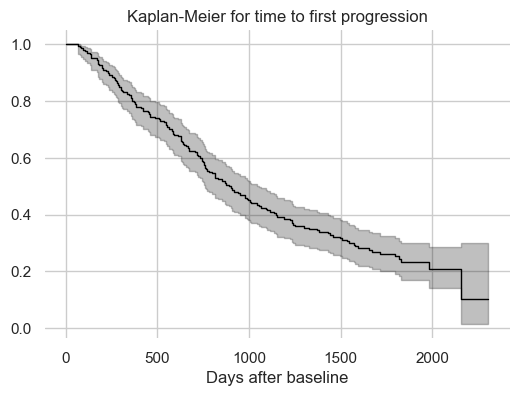

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
kaplan_meier_fitter = lifelines.KaplanMeierFitter()
durations = cohort_follow_ups_time_to_progression_for_lifelines["duration"]
observed = cohort_follow_ups_time_to_progression_for_lifelines["observed"]
kaplan_meier_fitter.fit(
    durations=durations,
    event_observed=observed,
)
kaplan_meier_fitter.plot_survival_function(
    color="black",
    linewidth=1,
    legend=False,
)
ax.set_title("Kaplan-Meier for time to first progression")
ax.set_xlabel("Days after baseline")
sns.despine(bottom=True, left=True, right=True, top=True)
plt.show()